In [24]:
from psycopg2 import connect
import configparser
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Purpose

Understand how long people have to wait at the station before bording a train.

### Known issues
* Reported times outside of normal operating hours skewing results

#### Note: queries tested over 2019-09 data

# Create connection and view sample data

In [3]:
CONFIG = configparser.ConfigParser(interpolation=None)
CONFIG.read('./ttc_db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

In [4]:
sql = '''
SELECT *
FROM ntas_data
LIMIT 1
'''

with con.cursor() as cur:
    cur.execute(sql)
    colnames = (desc[0] for desc in cur.description)
    values = cur.fetchone()
    print(list(zip(colnames, values)))

[('requestid', 1), ('id', 32909720863), ('station_char', 'SHW1'), ('subwayline', 'YUS'), ('system_message_type', 'Normal'), ('timint', Decimal('0.0')), ('traindirection', 'North'), ('trainid', 132), ('train_message', 'AtStation'), ('train_dest', 'Southbound<br/> To Union')]


# Create materialized views

### `closest_trains`: the API by default returns 3 trains for each station, but we are only interested in the closest one, based on `timint` column
Columns: subwayline, station_char, trainid, timint, train_message, requestid

In [5]:
sql = '''
DROP MATERIALIZED VIEW IF EXISTS closest_trains CASCADE; 
CREATE MATERIALIZED VIEW closest_trains AS 
  WITH closest_trains AS (
    SELECT subwayline, station_char, trainid, timint, train_message, requestid,
    RANK() OVER (PARTITION BY subwayline, station_char, requestid ORDER BY timint) as train_order
    FROM ntas_data
  )
  SELECT subwayline, station_char, trainid, timint, train_message, requestid
  FROM closest_trains
  WHERE train_order = 1
''' 
with con:
    with con.cursor() as cur:
        cur.execute(sql)

# Data exploration

### Summary of reported wait times for next train

In [7]:
pd.set_option('float_format', '{0:.2f}'.format)

sql = '''
SELECT timint
FROM closest_trains
'''
data = pd.read_sql(sql, con)
data.describe()

,timint
count,4466205.00
mean,2.14
std,3.33
min,0.00
25%,0.29
50%,1.32
75%,2.78
max,67.16


### Top and Bottom 10 stations with shortest reported wait times (median)

In [11]:
sql = '''
select station_char, percentile_disc(0.5) within group (order by timint) as next_train
from closest_trains
group by station_char
order by next_train
'''
data = pd.read_sql(sql, con)
data.head(10)

,station_char,next_train
0,KIP1,0.00
1,FIN1,0.00
2,FIN2,0.00
3,VMC1,0.00
4,VMC2,0.00
5,KEN1,0.00
6,KEN2,0.00
7,KIP2,0.00
8,YIE1,0.50
9,UNI1,0.69


* terminal stations often have a train waiting, but it doesn't mean it's going to leave soon

In [13]:
data.tail(10)

,station_char,next_train
138,YIE2,2.30
139,YKM2,2.37
140,FIW1,2.38
141,DUP1,2.40
142,DNP2,2.70
143,FIW2,2.74
144,DNP1,2.81
145,SHW2,2.86
146,BYV2,2.91
147,LES1,3.12


### Hours with shortest reported wait time by day of the week

In [33]:
sql = '''
select case when extract(dow from create_date) between 1 and 5 then 'week' else 'weekend' end as week,
  extract(hour from create_date) as hour,
  percentile_disc(0.5) within group (order by timint) as next_train
from closest_trains
join requests using (requestid)
group by hour, week
order by hour, week
'''
data = pd.read_sql(sql, con)

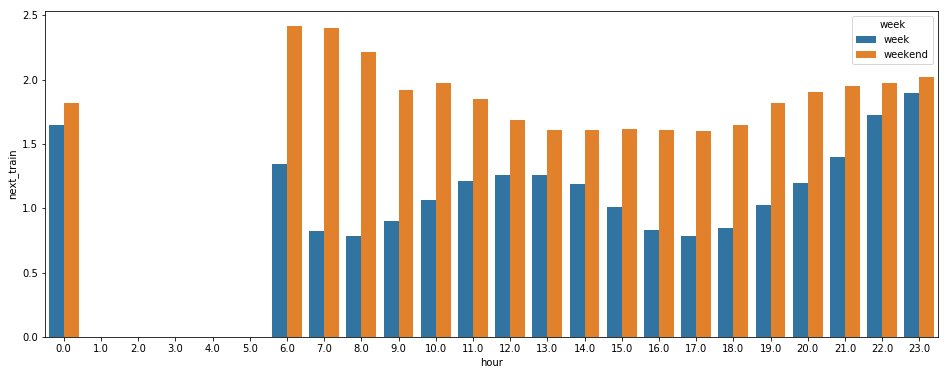

In [34]:
# numbers were high outside of normal subway hours, so set to none to avoid stretching chart
data.loc[data['hour'].between(1, 5), 'next_train'] = None
plt.figure(figsize=(16, 6))
ax = sns.barplot(x="hour", y="next_train", hue="week", data=data)

### How often / when / where reported wait times were over 3 minutes?

In [50]:
sql = '''
select case when extract(dow from create_date) between 1 and 5 then 'week' else 'weekend' end as week,
  extract(day from create_date) as day,
  extract(hour from create_date) as hour,
  COUNT(1) as total, SUM(CASE WHEN timint > 3 THEN 1 ELSE 0 END) as late
from closest_trains
join requests using (requestid)
where extract(hour from create_date) between 6 and 24
group by 1, 2, 3
order by 5 desc
'''
data = pd.read_sql(sql, con)

In [52]:
data['percentage'] = data['late']/data['total']
data.sort_values('percentage', ascending=False, inplace=True)
data[data['percentage']>0.5]

,week,day,hour,total,late,percentage
100,weekend,8.00,6.00,2873,2358,0.82
193,weekend,1.00,7.00,2171,1653,0.76
197,weekend,8.00,7.00,2193,1647,0.75
